# Fetch Taxi Zone data

In [1]:
import geopandas as gpd
import folium
import pandas as pd
import os
import polyline
import requests
import json
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

import matplotlib.pyplot as plt

root_folder = "/home/trungdc/unimelb/MAST30024/asm/project 1/"
data_dir = os.path.join(root_folder, "Data","Taxi Zones")


In [13]:
df = gpd.read_file(os.path.join(data_dir, "taxi_zones/taxi_zones.shp"))
zone = pd.read_csv(os.path.join(data_dir,"taxi+_zone_lookup.csv"))
df['geometry'] = df['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
df["Centroid"] = df["geometry"].apply(lambda multipolygon: multipolygon.centroid.wkt)

In [14]:
df.sort_values("LocationID", ascending=True,  inplace = True)
processed_Centroids = []
for index, row in df.iterrows():
    processed_Centroid = [float(item) for item in row["Centroid"][7:][:-1].split(" ")]
    processed_Centroids.append(processed_Centroid)
df["Processed Centroid"] = processed_Centroids
df.drop("Centroid", axis = 1, inplace=True)
df.to_csv(os.path.join(data_dir, "taxi_zones_processed.csv"))
df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,Processed Centroid
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...","[-74.17400027276295, 40.69183120640135]"
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...","[-73.83129854302251, 40.61674529165992]"
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...","[-73.84742223236725, 40.86447368477535]"
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...","[-73.97696825691766, 40.72375214158463]"
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...","[-74.18848410184938, 40.55265928694553]"


# Extract OSMR features

## Intruction on setting up OSMR Backend with Docker on Ubuntu 20.04
Please follow this [repo](https://github.com/Project-OSRM/osrm-backend) if you have any problem

0. Install Docker and go to OSMR directory
```
    cd OSMR_folder
```
1. Download NYC pbf file
    ```
    !wget http://download.geofabrik.de/north-america/us/new-york-latest.osm.pbf
    ```
2. Pre-process the extract 
```
    docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/new-york-latest.osm.pb
```
3. Setting up container
```
    docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-partition /data/new-york-latest.osm.pbf
    docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-customize /data/new-york-latest.osm.pbf
```
4. Start the container on port 5000
```
    docker run -t -i -p 5000:5000 -v "${PWD}:/data" osrm/osrm-backend osrm-routed --algorithm mld /data/new-york-latest.osrm
```
NOTE: make sure the container is running before running the following two cells


In [17]:
def process_OSMR_output(OSMR_Output : json):
    """
    Extracting important feature from OSMR output
        Parameters:
            OSMR_Output (json) : filename of OSRM output
        Returns:
            features (dict): Extracted features including the following fields:
                - geometry: Poliline encoder for visualisation of the route
                - total_distance: distance of nearest route between two Taxi Zone Centroid in meters
                - total_duration: duration of nearest route between two Taxi Zone Centroid in seconds
                - main_road: List of main road names of the route 
                - segment_road: List of road segment in the route has this form 
                    [name of segment, duration of traveling through segment, distance of segment]
                - AVG_speed_OSRM: Average speed through out the route in km/h

    """
    features = {}
    startnode = OSMR_Output["routes"][0]
    features["geometry"] = startnode["geometry"]
    features["total_distance"] = startnode["legs"][0]["distance"]
    features["total_duration"] = startnode["legs"][0]["duration"]
    features["main_road"] = startnode["legs"][0]["summary"].split(",")
    features["segment_road"] = [[routeleg["name"], routeleg["duration"], routeleg["distance"] ] for routeleg in startnode["legs"][0]["steps"]]
    features["AVG_speed_OSRM"] = (features["total_distance"]/1000)/(features["total_duration"]/(60*60))
    return features

In [ ]:
output_OSRM_dataframe = []
for pickupid in df["LocationID"].values:
    for dropoffid in df["LocationID"].values:

        # cannot extract features for cases when pickupid and dropoffid are the same
        if pickupid == dropoffid:
            continue
    
        pickuppos = df[df.LocationID == pickupid]["Processed Centroid"].values[0]
        dropoffpos = df[df.LocationID == dropoffid]["Processed Centroid"].values[0]
        pickup_lon, pickup_lat, dropoff_lon, dropoff_lat = pickuppos[0], pickuppos[1], dropoffpos[0],dropoffpos[1]

        loc = "{},{};{},{}".format(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat)
        url = "http://127.0.0.1:5000/route/v1/driving/"
        r = requests.get(url + loc + "?alternatives=false&steps=true&overview=full") 
        if r.status_code!= 200:
            res = {}

        res = r.json()   
        with open(os.path.join(os.path.join(root_folder, "Data", "OSRM/OSRM_Output"), str(pickupid)+ "-"+ str(dropoffid) +'.txt'), 'w')as outfile:
            json.dump(res, outfile)
        
        output = process_OSMR_output(res)
        output["Key"] = f"{pickupid}-{dropoffid}"
        output_OSRM_dataframe.append(output)
pd.DataFrame(output_OSRM_dataframe).to_csv(os.path.join(root_folder,"Data", "OSRM", "OSRM.csv"))

# Demo for OSMR Project

In [11]:
def get_route(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat):
    
    loc = "{},{};{},{}".format(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat)
    url = "http://127.0.0.1:5000/route/v1/driving/"
    r = requests.get(url + loc + "?alternatives=false&steps=true&overview=full") 
    if r.status_code!= 200:
        return {}
  
    res = r.json()   
    routes = polyline.decode(res['routes'][0]['geometry'])
    start_point = [res['waypoints'][0]['location'][1], res['waypoints'][0]['location'][0]]
    end_point = [res['waypoints'][1]['location'][1], res['waypoints'][1]['location'][0]]
    distance = res['routes'][0]['distance']
    
    out = {'route':routes,
           'start_point':start_point,
           'end_point':end_point,
           'distance':distance
          }

    return out
pickup_lon, pickup_lat, dropoff_lon, dropoff_lat = -74.17400027276304,40.69183120640133,-73.83129854302213,40.61674529165957
test_route = get_route(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat)
test_route
def get_map(route):
    
    m = folium.Map(location=[(route['start_point'][0] + route['end_point'][0])/2, 
                             (route['start_point'][1] + route['end_point'][1])/2], 
                   zoom_start=12)

    folium.PolyLine(
        route['route'],
        weight=8,
        color='blue',
        opacity=0.6
    ).add_to(m)

    folium.Marker(
        location=route['start_point'],
        icon=folium.Icon(icon='play', color='green')
    ).add_to(m)

    folium.Marker(
        location=route['end_point'],
        icon=folium.Icon(icon='stop', color='red')
    ).add_to(m)

    return m
get_map(test_route)

# Import data for cleaning & EDA

In [2]:
df = pd.read_csv(os.path.join(root_folder,"Data", "OSRM", "OSRM.csv"))
df.drop(["Unnamed: 0",'segment_road'], inplace= True, axis = 1)
df.columns = ['geometry', 'expected_total_distance', 'expected_total_duration',
       'expected_main_road','Expected_AVG_speed', 'Key']
df.head()

,geometry,expected_total_distance,expected_total_duration,expected_main_road,Expected_AVG_speed,Key
0,ebawFdnxcMl@q@n@_AnKfNnGvIr@cAZe@^i@~HmMVaAjAe...,46340.8,2806.0,"['Staten Island Expressway', ' Belt Parkway']",59.453628,1-2
1,ebawFdnxcMl@q@n@_AnKfNnGvIr@cAZe@^i@~HmMVaAjAe...,61176.5,3823.1,"['Staten Island Expressway', ' Brooklyn-Queens...",57.606497,1-3
2,ebawFdnxcMl@q@n@_AnKfNnGvIr@cAZe@^i@~HmMVaAjAe...,33650.4,2488.2,"['Staten Island Expressway', ' Gowanus Express...",48.686376,1-4
3,ebawFdnxcMl@q@n@_AnKfNnGvIr@cAZe@^i@~HmMVaAjAe...,12559.6,1251.2,"['West Shore Expressway', ' W Shore Exwy W Sta...",36.136957,1-5
4,ebawFdnxcMl@q@n@_AnKfNnGvIr@cAZe@^i@~HmMVaAjAe...,13134.0,1115.9,"['Staten Island Expressway', ' Staten Island E...",42.371539,1-6


In [8]:
more_row = []
for id in range(1,264):
    row = { "geometry": 0, "expected_total_distance":0, "expected_total_duration":0,"expected_main_road": 0
    , "Expected_AVG_speed":0, "Key": str(id)+"-"+str(id)   }
    more_row.append(row)
more_row = pd.DataFrame(more_row)


In [13]:
merge = pd.concat([df,more_row])
len(merge)
merge.to_csv(os.path.join(root_folder,"Data", "OSRM", "OSRM_plus.csv"))

(array([   67.,  1542.,  4114.,  8375., 14475., 18813., 15183.,  5393.,
          897.,    39.]),
 array([17.91598465, 24.36465873, 30.81333281, 37.26200689, 43.71068097,
        50.15935505, 56.60802913, 63.05670321, 69.50537729, 75.95405137,
        82.40272545]),
 <BarContainer object of 10 artists>)

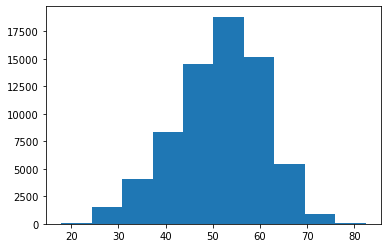

In [23]:
plt.hist(df["Expected_AVG_speed"])

(array([ 4075., 12618., 18133., 16310.,  8778.,  4734.,  2432.,  1255.,
          488.,    75.]),
 array([0.0145    , 0.13416111, 0.25382222, 0.37348333, 0.49314444,
        0.61280556, 0.73246667, 0.85212778, 0.97178889, 1.09145   ,
        1.21111111]),
 <BarContainer object of 10 artists>)

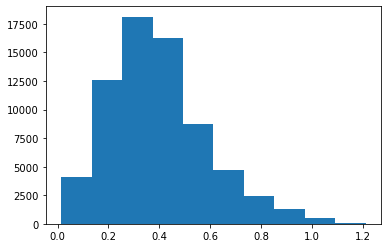

In [24]:
plt.hist(df["expected_total_duration"]/3600)

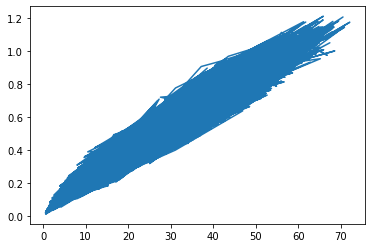

In [25]:
plt.plot(df["expected_total_distance"]/1000, df["expected_total_duration"]/3600)